In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v2 import Autoencoder
from tools.ESN_v2_AR import ESN as AR_RNN_ESN
from tools.AEESN_AR_v1 import AR_AERNN_ESN
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-02-22 01:35:26.943712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-02-22 01:35:26.943984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 01:35:26.998806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 01:35:26.999202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 01:35:26.999600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 01:35:26.999883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_004'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_rnn_014'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in AR_RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        normalization_type = params_AR_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in AR_RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    covmat_lmda = tparams_dict['covmat_lmda']
    try:
        lambda_reg = tparams_dict['lambda_reg']
    except:
        lambda_reg = 1e-6
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']

with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('data_dir_idx:', data_dir_idx)
print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx

with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005
data_dir_idx: 000
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_013
24 <class 'int'>


In [12]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [13]:
lyap_time = 1/0.065
delta_t = 1.
T = t_recorded_samples[-1]

In [14]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (100001, 2, 50, 50)


In [15]:
all_data = all_data[0:int(all_data.shape[0]/3)]

In [16]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (33333, 2, 50, 50)


# Autoencoder

In [17]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [18]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# ESN

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50])*dt_rnn/lyap_time
    num_timesteps_warmup = 1*lyap_time/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*lyap_time
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        # 'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_ESN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [20]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [2e-5],
        [1e-5],
        [2e-6],
        [1e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
    ]
    patience = [
        [50],
        [50],
        [50],
        [50],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-7  # weight for regularizer
    covmat_lmda = 1e-3  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 16
    
    train_alpha = [False]*3
    train_omega_in = [False]*3
    train_rho_res = [False]*3
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
        'lambda_reg':lambda_reg,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [21]:
rnn_kwargs = {}
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_ESN_weights.hdf5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'
    
    rnn_kwargs = {
        'train_alpha':train_alpha,
        'train_omega_in':train_omega_in,
        'train_rho_res':train_rho_res,
    }

In [22]:
%pdb

Automatic pdb calling has been turned ON




********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


2023-02-22 01:35:56.413075: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


(497, 62, 5000) (497, 5, 5000)


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
25/25 [==============================] - ETA: 0s - loss: 0.1081 - mse: 0.0126 - NMSE: 0.1145 - covmat_fro_loss: 0.0234 - global_gradnorm: 10.0352 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 0m 36.6s

Epoch 1: val_NMSE improved from inf to 0.10085, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 36s 690ms/step - loss: 0.1081 - mse: 0.0126 - NMSE: 0.1145 - covmat_fro_loss: 0.0233 - global_gradnorm: 9

25/25 [==============================] - ETA: 0s - loss: 0.0320 - mse: 0.0037 - NMSE: 0.0338 - covmat_fro_loss: 0.0138 - global_gradnorm: 5.4293 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 2m 31.9s

Epoch 9: val_NMSE did not improve from 0.04841
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 14s 579ms/step - loss: 0.0320 - mse: 0.0037 - NMSE: 0.0338 - covmat_fro_loss: 0.0138 - global_gradnorm: 5.4360 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0458 - val_mse: 0.0053 - val_NMSE: 0.0485 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
25/25 [==============================] - ETA: 0s - loss: 0.0312 - mse: 0.0036 - NMSE: 0.0329 - covmat_fro_loss: 0.0135 - global_gradnorm: 5.2594 - rho

25/25 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0030 - NMSE: 0.0271 - covmat_fro_loss: 0.0124 - global_gradnorm: 4.3261 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 4m 42.5s

Epoch 18: val_NMSE did not improve from 0.04664
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 536ms/step - loss: 0.0257 - mse: 0.0030 - NMSE: 0.0271 - covmat_fro_loss: 0.0124 - global_gradnorm: 4.3544 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0447 - val_mse: 0.0052 - val_NMSE: 0.0474 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 19/1000
25/25 [==============================] - ETA: 0s - loss: 0.0248 - mse: 0.0029 - NMSE: 0.0262 - covmat_fro_loss: 0.0123 - global_gradnorm: 4.2480 - rh

25/25 [==============================] - ETA: 0s - loss: 0.0217 - mse: 0.0025 - NMSE: 0.0229 - covmat_fro_loss: 0.0115 - global_gradnorm: 3.7231 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 6m 48.9s

Epoch 27: val_NMSE did not improve from 0.04240
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 526ms/step - loss: 0.0217 - mse: 0.0025 - NMSE: 0.0229 - covmat_fro_loss: 0.0115 - global_gradnorm: 3.7136 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0472 - val_mse: 0.0055 - val_NMSE: 0.0500 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 28/1000
25/25 [==============================] - ETA: 0s - loss: 0.0200 - mse: 0.0023 - NMSE: 0.0211 - covmat_fro_loss: 0.0110 - global_gradnorm: 3.5519 - rh

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 527ms/step - loss: 0.0167 - mse: 0.0019 - NMSE: 0.0176 - covmat_fro_loss: 0.0103 - global_gradnorm: 2.8266 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0398 - val_mse: 0.0046 - val_NMSE: 0.0421 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 37/1000
25/25 [==============================] - ETA: 0s - loss: 0.0171 - mse: 0.0020 - NMSE: 0.0180 - covmat_fro_loss: 0.0103 - global_gradnorm: 2.7686 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 9m 7.3s

Epoch 37: val_NMSE did not improve from 0.04140
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outst

Epoch 46/1000
25/25 [==============================] - ETA: 0s - loss: 0.0159 - mse: 0.0018 - NMSE: 0.0167 - covmat_fro_loss: 0.0100 - global_gradnorm: 2.7898 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 11m 13.7s

Epoch 46: val_NMSE did not improve from 0.03799
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 14s 544ms/step - loss: 0.0159 - mse: 0.0018 - NMSE: 0.0167 - covmat_fro_loss: 0.0101 - global_gradnorm: 2.7924 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0410 - val_mse: 0.0048 - val_NMSE: 0.0434 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 47/1000
25/25 [==============================] - ETA: 0s - loss: 0.0175 - mse: 0.0020 - NMSE: 0.0184 - covmat_fro_loss: 0.0103 - global_gradno

Epoch 56/1000
25/25 [==============================] - ETA: 0s - loss: 0.0176 - mse: 0.0020 - NMSE: 0.0185 - covmat_fro_loss: 0.0103 - global_gradnorm: 2.8556 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 13m 32.3s

Epoch 56: val_NMSE did not improve from 0.03799
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 14s 575ms/step - loss: 0.0176 - mse: 0.0020 - NMSE: 0.0185 - covmat_fro_loss: 0.0103 - global_gradnorm: 2.8461 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0388 - val_mse: 0.0045 - val_NMSE: 0.0411 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 57/1000
25/25 [==============================] - ETA: 0s - loss: 0.0154 - mse: 0.0018 - NMSE: 0.0162 - covmat_fro_loss: 0.0097 - global_gradno

Epoch 66/1000
25/25 [==============================] - ETA: 0s - loss: 0.0137 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0093 - global_gradnorm: 2.3544 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 15m 51.6s

Epoch 66: val_NMSE did not improve from 0.03799
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 14s 585ms/step - loss: 0.0137 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0093 - global_gradnorm: 2.3604 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0371 - val_mse: 0.0043 - val_NMSE: 0.0393 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 67/1000
25/25 [==============================] - ETA: 0s - loss: 0.0141 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0093 - global_gradno

Epoch 76/1000
25/25 [==============================] - ETA: 0s - loss: 0.0128 - mse: 0.0015 - NMSE: 0.0135 - covmat_fro_loss: 0.0090 - global_gradnorm: 1.9708 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 18m 11.2s

Epoch 76: val_NMSE did not improve from 0.03795
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 14s 569ms/step - loss: 0.0128 - mse: 0.0015 - NMSE: 0.0135 - covmat_fro_loss: 0.0090 - global_gradnorm: 1.9801 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0362 - val_mse: 0.0042 - val_NMSE: 0.0383 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 77/1000
25/25 [==============================] - ETA: 0s - loss: 0.0131 - mse: 0.0015 - NMSE: 0.0138 - covmat_fro_loss: 0.0090 - global_gradno

Epoch 86/1000
25/25 [==============================] - ETA: 0s - loss: 0.0135 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0091 - global_gradnorm: 1.9710 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 20m 29.1s

Epoch 86: val_NMSE did not improve from 0.03779
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 525ms/step - loss: 0.0135 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0091 - global_gradnorm: 1.9728 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0397 - val_mse: 0.0046 - val_NMSE: 0.0420 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 87/1000
25/25 [==============================] - ETA: 0s - loss: 0.0120 - mse: 0.0014 - NMSE: 0.0126 - covmat_fro_loss: 0.0086 - global_gradno

Epoch 96/1000
25/25 [==============================] - ETA: 0s - loss: 0.0129 - mse: 0.0015 - NMSE: 0.0135 - covmat_fro_loss: 0.0090 - global_gradnorm: 2.0077 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 22m 47.1s

Epoch 96: val_NMSE did not improve from 0.03761
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 525ms/step - loss: 0.0129 - mse: 0.0015 - NMSE: 0.0135 - covmat_fro_loss: 0.0089 - global_gradnorm: 2.0026 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0372 - val_mse: 0.0043 - val_NMSE: 0.0394 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 97/1000
25/25 [==============================] - ETA: 0s - loss: 0.0127 - mse: 0.0015 - NMSE: 0.0133 - covmat_fro_loss: 0.0089 - global_gradno

Epoch 106/1000
25/25 [==============================] - ETA: 0s - loss: 0.0123 - mse: 0.0014 - NMSE: 0.0129 - covmat_fro_loss: 0.0087 - global_gradnorm: 1.7452 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 25m 4.9s

Epoch 106: val_NMSE did not improve from 0.03761
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 14s 552ms/step - loss: 0.0123 - mse: 0.0014 - NMSE: 0.0129 - covmat_fro_loss: 0.0087 - global_gradnorm: 1.7451 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0369 - val_mse: 0.0043 - val_NMSE: 0.0391 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 107/1000
25/25 [==============================] - ETA: 0s - loss: 0.0118 - mse: 0.0014 - NMSE: 0.0124 - covmat_fro_loss: 0.0086 - global_grad

Epoch 116/1000
25/25 [==============================] - ETA: 0s - loss: 0.0109 - mse: 0.0013 - NMSE: 0.0115 - covmat_fro_loss: 0.0082 - global_gradnorm: 1.6081 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 27m 23.7s

Epoch 116: val_NMSE did not improve from 0.03729
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 14s 571ms/step - loss: 0.0109 - mse: 0.0013 - NMSE: 0.0115 - covmat_fro_loss: 0.0082 - global_gradnorm: 1.6039 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0360 - val_mse: 0.0042 - val_NMSE: 0.0381 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 117/1000
25/25 [==============================] - ETA: 0s - loss: 0.0117 - mse: 0.0014 - NMSE: 0.0122 - covmat_fro_loss: 0.0084 - global_gra

Epoch 126/1000
25/25 [==============================] - ETA: 0s - loss: 0.0112 - mse: 0.0013 - NMSE: 0.0118 - covmat_fro_loss: 0.0082 - global_gradnorm: 1.4996 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 29m 46.1s

Epoch 126: val_NMSE did not improve from 0.03710
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 539ms/step - loss: 0.0112 - mse: 0.0013 - NMSE: 0.0118 - covmat_fro_loss: 0.0082 - global_gradnorm: 1.5022 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0358 - val_mse: 0.0042 - val_NMSE: 0.0379 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 127/1000
25/25 [==============================] - ETA: 0s - loss: 0.0107 - mse: 0.0012 - NMSE: 0.0112 - covmat_fro_loss: 0.0081 - global_gra

Epoch 136/1000
25/25 [==============================] - ETA: 0s - loss: 0.0111 - mse: 0.0013 - NMSE: 0.0117 - covmat_fro_loss: 0.0082 - global_gradnorm: 1.3971 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 32m 4.5s

Epoch 136: val_NMSE did not improve from 0.03710
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 527ms/step - loss: 0.0111 - mse: 0.0013 - NMSE: 0.0117 - covmat_fro_loss: 0.0082 - global_gradnorm: 1.3927 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0363 - val_mse: 0.0042 - val_NMSE: 0.0384 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 137/1000
25/25 [==============================] - ETA: 0s - loss: 0.0103 - mse: 0.0012 - NMSE: 0.0108 - covmat_fro_loss: 0.0080 - global_grad

Epoch 146/1000
25/25 [==============================] - ETA: 0s - loss: 0.0106 - mse: 0.0012 - NMSE: 0.0111 - covmat_fro_loss: 0.0080 - global_gradnorm: 1.4123 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 34m 22.0s

Epoch 146: val_NMSE did not improve from 0.03710
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 520ms/step - loss: 0.0106 - mse: 0.0012 - NMSE: 0.0111 - covmat_fro_loss: 0.0080 - global_gradnorm: 1.4060 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0356 - val_mse: 0.0042 - val_NMSE: 0.0377 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 147/1000
25/25 [==============================] - ETA: 0s - loss: 0.0114 - mse: 0.0013 - NMSE: 0.0119 - covmat_fro_loss: 0.0082 - global_gra

Epoch 156/1000
25/25 [==============================] - ETA: 0s - loss: 0.0111 - mse: 0.0013 - NMSE: 0.0117 - covmat_fro_loss: 0.0081 - global_gradnorm: 1.3644 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 36m 39.3s

Epoch 156: val_NMSE did not improve from 0.03688
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 521ms/step - loss: 0.0111 - mse: 0.0013 - NMSE: 0.0117 - covmat_fro_loss: 0.0081 - global_gradnorm: 1.3573 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0358 - val_mse: 0.0042 - val_NMSE: 0.0379 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 157/1000
25/25 [==============================] - ETA: 0s - loss: 0.0100 - mse: 0.0012 - NMSE: 0.0105 - covmat_fro_loss: 0.0078 - global_gra

Epoch 166/1000
25/25 [==============================] - ETA: 0s - loss: 0.0096 - mse: 0.0011 - NMSE: 0.0101 - covmat_fro_loss: 0.0077 - global_gradnorm: 1.2470 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 38m 56.1s

Epoch 166: val_NMSE did not improve from 0.03688
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 528ms/step - loss: 0.0096 - mse: 0.0011 - NMSE: 0.0101 - covmat_fro_loss: 0.0077 - global_gradnorm: 1.2347 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0364 - val_mse: 0.0042 - val_NMSE: 0.0385 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 167/1000
25/25 [==============================] - ETA: 0s - loss: 0.0093 - mse: 0.0011 - NMSE: 0.0098 - covmat_fro_loss: 0.0077 - global_gra

Epoch 176/1000
25/25 [==============================] - ETA: 0s - loss: 0.0098 - mse: 0.0011 - NMSE: 0.0102 - covmat_fro_loss: 0.0077 - global_gradnorm: 1.2322 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 41m 12.9s

Epoch 176: val_NMSE did not improve from 0.03688
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 526ms/step - loss: 0.0098 - mse: 0.0011 - NMSE: 0.0102 - covmat_fro_loss: 0.0077 - global_gradnorm: 1.2326 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0364 - val_mse: 0.0043 - val_NMSE: 0.0386 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 177/1000
25/25 [==============================] - ETA: 0s - loss: 0.0088 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0073 - global_gra

Epoch 186/1000
25/25 [==============================] - ETA: 0s - loss: 0.0100 - mse: 0.0012 - NMSE: 0.0104 - covmat_fro_loss: 0.0078 - global_gradnorm: 1.2545 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 43m 30.4s

Epoch 186: val_NMSE did not improve from 0.03688
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 532ms/step - loss: 0.0100 - mse: 0.0012 - NMSE: 0.0104 - covmat_fro_loss: 0.0078 - global_gradnorm: 1.2554 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0359 - val_mse: 0.0042 - val_NMSE: 0.0380 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 187/1000
25/25 [==============================] - ETA: 0s - loss: 0.0098 - mse: 0.0011 - NMSE: 0.0103 - covmat_fro_loss: 0.0078 - global_gra

Epoch 196/1000
25/25 [==============================] - ETA: 0s - loss: 0.0108 - mse: 0.0013 - NMSE: 0.0114 - covmat_fro_loss: 0.0080 - global_gradnorm: 1.2108 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 45m 48.0s

Epoch 196: val_NMSE did not improve from 0.03688
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 522ms/step - loss: 0.0108 - mse: 0.0013 - NMSE: 0.0114 - covmat_fro_loss: 0.0080 - global_gradnorm: 1.2240 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0376 - val_mse: 0.0044 - val_NMSE: 0.0398 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 197/1000
25/25 [==============================] - ETA: 0s - loss: 0.0099 - mse: 0.0011 - NMSE: 0.0104 - covmat_fro_loss: 0.0077 - global_gra

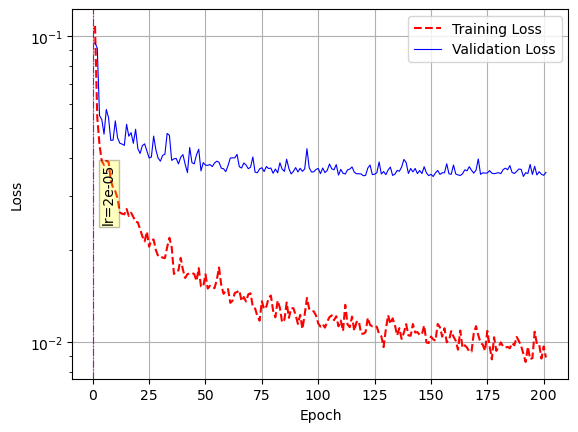

<Figure size 640x480 with 0 Axes>

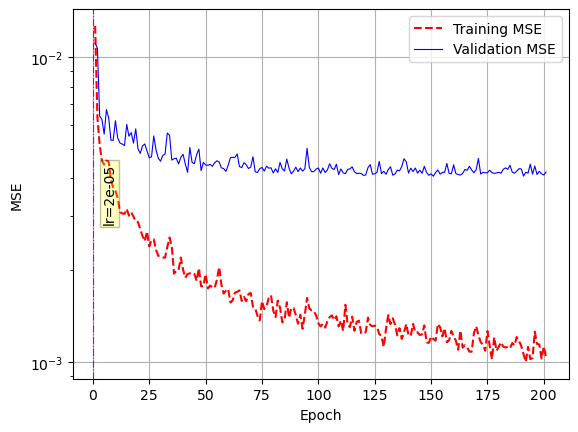

<Figure size 640x480 with 0 Axes>

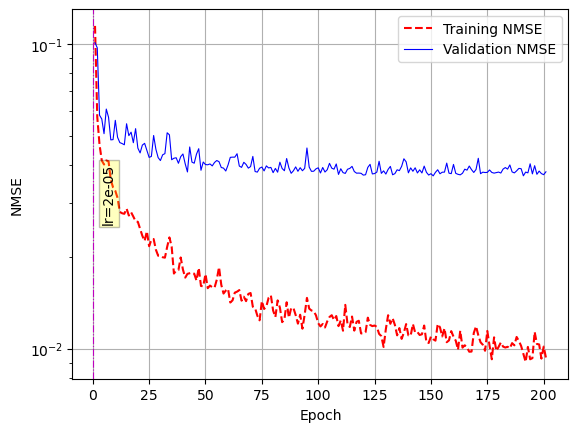

<Figure size 640x480 with 0 Axes>

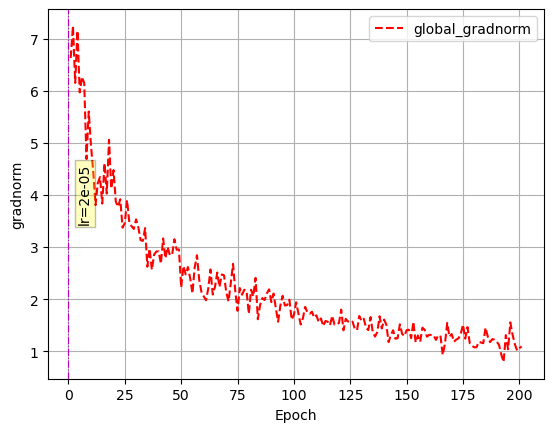

<Figure size 640x480 with 0 Axes>

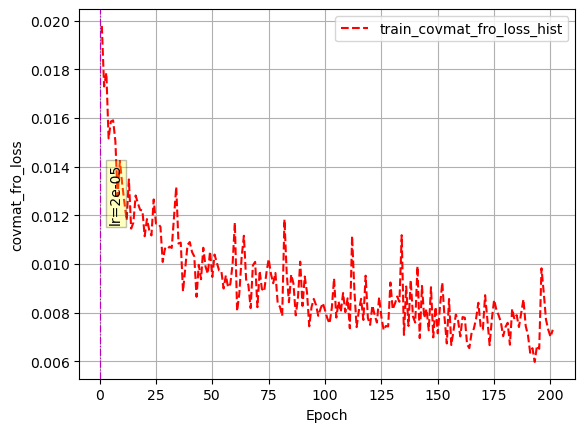



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 6.525
(462, 62, 5000) (462, 10, 5000)


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
22/22 [==============================] - ETA: 0s - loss: 0.0653 - mse: 0.0082 - NMSE: 0.0738 - covmat_fro_loss: 0.0175 - global_gradnorm: 4.8496 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 0m 44.9s

Epoch 1: val_NMSE improved from inf to 0.07162, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-10_outsteps
 - saving l

22/22 [==============================] - ETA: 0s - loss: 0.0316 - mse: 0.0039 - NMSE: 0.0354 - covmat_fro_loss: 0.0132 - global_gradnorm: 3.2558 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 2m 47.6s

Epoch 9: val_NMSE did not improve from 0.06250
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 14s 646ms/step - loss: 0.0316 - mse: 0.0039 - NMSE: 0.0354 - covmat_fro_loss: 0.0133 - global_gradnorm: 3.2586 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0561 - val_mse: 0.0070 - val_NMSE: 0.0632 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
22/22 [==============================] - ETA: 0s - loss: 0.0307 - mse: 0.0038 - NMSE: 0.0344 - covmat_fro_loss: 0.0131 - global_gradnorm: 3.2826 - rh

Epoch 19/1000
22/22 [==============================] - ETA: 0s - loss: 0.0276 - mse: 0.0034 - NMSE: 0.0310 - covmat_fro_loss: 0.0125 - global_gradnorm: 3.1596 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 5m 14.4s

Epoch 19: val_NMSE did not improve from 0.06125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 14s 655ms/step - loss: 0.0276 - mse: 0.0034 - NMSE: 0.0310 - covmat_fro_loss: 0.0126 - global_gradnorm: 3.1510 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0569 - val_mse: 0.0071 - val_NMSE: 0.0641 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 20/1000
22/22 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0032 - NMSE: 0.0288 - covmat_fro_loss: 0.0121 - global_gradno

Epoch 29/1000
22/22 [==============================] - ETA: 0s - loss: 0.0221 - mse: 0.0027 - NMSE: 0.0248 - covmat_fro_loss: 0.0114 - global_gradnorm: 2.8503 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 7m 39.9s

Epoch 29: val_NMSE did not improve from 0.06125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 15s 669ms/step - loss: 0.0221 - mse: 0.0027 - NMSE: 0.0248 - covmat_fro_loss: 0.0114 - global_gradnorm: 2.8502 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0553 - val_mse: 0.0069 - val_NMSE: 0.0622 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 30/1000
22/22 [==============================] - ETA: 0s - loss: 0.0235 - mse: 0.0029 - NMSE: 0.0263 - covmat_fro_loss: 0.0117 - global_gradno

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 15s 671ms/step - loss: 0.0216 - mse: 0.0027 - NMSE: 0.0242 - covmat_fro_loss: 0.0112 - global_gradnorm: 2.9691 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0545 - val_mse: 0.0068 - val_NMSE: 0.0614 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 39/1000
22/22 [==============================] - ETA: 0s - loss: 0.0219 - mse: 0.0027 - NMSE: 0.0245 - covmat_fro_loss: 0.0113 - global_gradnorm: 3.2120 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 10m 7.7s

Epoch 39: val_NMSE improved from 0.06049 to 0.06026, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-10_outsteps
 - saving los

Epoch 48/1000
22/22 [==============================] - ETA: 0s - loss: 0.0185 - mse: 0.0023 - NMSE: 0.0207 - covmat_fro_loss: 0.0106 - global_gradnorm: 2.6402 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 12m 20.7s

Epoch 48: val_NMSE did not improve from 0.06026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 15s 668ms/step - loss: 0.0185 - mse: 0.0023 - NMSE: 0.0207 - covmat_fro_loss: 0.0107 - global_gradnorm: 2.6759 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0573 - val_mse: 0.0071 - val_NMSE: 0.0646 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 49/1000
22/22 [==============================] - ETA: 0s - loss: 0.0206 - mse: 0.0026 - NMSE: 0.0231 - covmat_fro_loss: 0.0111 - global_gradn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 15s 704ms/step - loss: 0.0192 - mse: 0.0024 - NMSE: 0.0214 - covmat_fro_loss: 0.0106 - global_gradnorm: 2.5032 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0527 - val_mse: 0.0066 - val_NMSE: 0.0594 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 58/1000
22/22 [==============================] - ETA: 0s - loss: 0.0199 - mse: 0.0025 - NMSE: 0.0222 - covmat_fro_loss: 0.0108 - global_gradnorm: 2.8280 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 14m 48.9s

Epoch 58: val_NMSE did not improve from 0.05938
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_o

Epoch 67/1000
22/22 [==============================] - ETA: 0s - loss: 0.0185 - mse: 0.0023 - NMSE: 0.0206 - covmat_fro_loss: 0.0104 - global_gradnorm: 2.7180 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 17m 1.7s

Epoch 67: val_NMSE did not improve from 0.05938
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 15s 669ms/step - loss: 0.0185 - mse: 0.0023 - NMSE: 0.0206 - covmat_fro_loss: 0.0104 - global_gradnorm: 2.7324 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0528 - val_mse: 0.0066 - val_NMSE: 0.0594 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 68/1000
22/22 [==============================] - ETA: 0s - loss: 0.0174 - mse: 0.0021 - NMSE: 0.0194 - covmat_fro_loss: 0.0102 - global_gradno

Epoch 77/1000
22/22 [==============================] - ETA: 0s - loss: 0.0182 - mse: 0.0022 - NMSE: 0.0203 - covmat_fro_loss: 0.0103 - global_gradnorm: 2.4854 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 19m 29.5s

Epoch 77: val_NMSE did not improve from 0.05890
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 15s 679ms/step - loss: 0.0182 - mse: 0.0022 - NMSE: 0.0203 - covmat_fro_loss: 0.0103 - global_gradnorm: 2.4692 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0538 - val_mse: 0.0067 - val_NMSE: 0.0605 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 78/1000
22/22 [==============================] - ETA: 0s - loss: 0.0182 - mse: 0.0022 - NMSE: 0.0204 - covmat_fro_loss: 0.0102 - global_gradn

Epoch 87/1000
22/22 [==============================] - ETA: 0s - loss: 0.0180 - mse: 0.0022 - NMSE: 0.0201 - covmat_fro_loss: 0.0103 - global_gradnorm: 2.8098 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 21m 57.1s

Epoch 87: val_NMSE did not improve from 0.05890
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 16s 726ms/step - loss: 0.0180 - mse: 0.0022 - NMSE: 0.0201 - covmat_fro_loss: 0.0103 - global_gradnorm: 2.7860 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0541 - val_mse: 0.0067 - val_NMSE: 0.0610 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 88/1000
22/22 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0026 - NMSE: 0.0231 - covmat_fro_loss: 0.0108 - global_gradn

Epoch 97/1000
22/22 [==============================] - ETA: 0s - loss: 0.0171 - mse: 0.0021 - NMSE: 0.0191 - covmat_fro_loss: 0.0100 - global_gradnorm: 2.4676 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 24m 32.7s

Epoch 97: val_NMSE did not improve from 0.05890
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 16s 718ms/step - loss: 0.0171 - mse: 0.0021 - NMSE: 0.0191 - covmat_fro_loss: 0.0099 - global_gradnorm: 2.4555 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0554 - val_mse: 0.0069 - val_NMSE: 0.0625 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 98/1000
22/22 [==============================] - ETA: 0s - loss: 0.0159 - mse: 0.0020 - NMSE: 0.0178 - covmat_fro_loss: 0.0098 - global_gradn

Epoch 107/1000
22/22 [==============================] - ETA: 0s - loss: 0.0151 - mse: 0.0019 - NMSE: 0.0169 - covmat_fro_loss: 0.0096 - global_gradnorm: 2.2267 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 27m 6.9s

Epoch 107: val_NMSE did not improve from 0.05890
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 15s 665ms/step - loss: 0.0151 - mse: 0.0019 - NMSE: 0.0169 - covmat_fro_loss: 0.0096 - global_gradnorm: 2.2106 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0547 - val_mse: 0.0068 - val_NMSE: 0.0616 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 108/1000
22/22 [==============================] - ETA: 0s - loss: 0.0146 - mse: 0.0018 - NMSE: 0.0162 - covmat_fro_loss: 0.0094 - global_gra

Epoch 117/1000
22/22 [==============================] - ETA: 0s - loss: 0.0166 - mse: 0.0020 - NMSE: 0.0185 - covmat_fro_loss: 0.0098 - global_gradnorm: 2.4357 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 29m 42.2s

Epoch 117: val_NMSE did not improve from 0.05855
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 15s 703ms/step - loss: 0.0166 - mse: 0.0020 - NMSE: 0.0185 - covmat_fro_loss: 0.0098 - global_gradnorm: 2.4355 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0543 - val_mse: 0.0068 - val_NMSE: 0.0612 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 118/1000
22/22 [==============================] - ETA: 0s - loss: 0.0160 - mse: 0.0020 - NMSE: 0.0179 - covmat_fro_loss: 0.0098 - global_gr

Epoch 127/1000
22/22 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0019 - NMSE: 0.0171 - covmat_fro_loss: 0.0096 - global_gradnorm: 2.4420 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 32m 20.6s

Epoch 127: val_NMSE did not improve from 0.05841
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 17s 775ms/step - loss: 0.0153 - mse: 0.0019 - NMSE: 0.0171 - covmat_fro_loss: 0.0096 - global_gradnorm: 2.4319 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0522 - val_mse: 0.0065 - val_NMSE: 0.0587 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 128/1000
22/22 [==============================] - ETA: 0s - loss: 0.0166 - mse: 0.0020 - NMSE: 0.0184 - covmat_fro_loss: 0.0097 - global_gr

Epoch 137/1000
22/22 [==============================] - ETA: 0s - loss: 0.0161 - mse: 0.0020 - NMSE: 0.0179 - covmat_fro_loss: 0.0097 - global_gradnorm: 2.5254 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 35m 3.1s

Epoch 137: val_NMSE did not improve from 0.05841
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 17s 774ms/step - loss: 0.0161 - mse: 0.0020 - NMSE: 0.0179 - covmat_fro_loss: 0.0098 - global_gradnorm: 2.5266 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0555 - val_mse: 0.0069 - val_NMSE: 0.0625 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 138/1000
22/22 [==============================] - ETA: 0s - loss: 0.0156 - mse: 0.0019 - NMSE: 0.0174 - covmat_fro_loss: 0.0096 - global_gra

Epoch 147/1000
22/22 [==============================] - ETA: 0s - loss: 0.0148 - mse: 0.0018 - NMSE: 0.0164 - covmat_fro_loss: 0.0093 - global_gradnorm: 2.2391 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 37m 44.1s

Epoch 147: val_NMSE improved from 0.05835 to 0.05834, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 18s 817ms/step - loss: 0.0148 - mse: 0.0018 - NMSE: 0.0164 - covmat_fro_loss: 0.0093 - global_gradnorm: 2.2272 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0518 - val_mse: 0.0064 - val_NMSE: 0.0583 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 148/

Epoch 157/1000
22/22 [==============================] - ETA: 0s - loss: 0.0158 - mse: 0.0019 - NMSE: 0.0176 - covmat_fro_loss: 0.0097 - global_gradnorm: 2.4923 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 40m 24.1s

Epoch 157: val_NMSE did not improve from 0.05834
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 17s 769ms/step - loss: 0.0158 - mse: 0.0019 - NMSE: 0.0176 - covmat_fro_loss: 0.0097 - global_gradnorm: 2.4914 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0546 - val_mse: 0.0068 - val_NMSE: 0.0615 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 158/1000
22/22 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0019 - NMSE: 0.0170 - covmat_fro_loss: 0.0095 - global_gr

Epoch 167/1000
22/22 [==============================] - ETA: 0s - loss: 0.0137 - mse: 0.0017 - NMSE: 0.0152 - covmat_fro_loss: 0.0089 - global_gradnorm: 2.0962 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 43m 4.0s

Epoch 167: val_NMSE did not improve from 0.05834
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 15s 691ms/step - loss: 0.0137 - mse: 0.0017 - NMSE: 0.0152 - covmat_fro_loss: 0.0090 - global_gradnorm: 2.0910 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0523 - val_mse: 0.0065 - val_NMSE: 0.0589 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 168/1000
22/22 [==============================] - ETA: 0s - loss: 0.0137 - mse: 0.0017 - NMSE: 0.0153 - covmat_fro_loss: 0.0090 - global_gra

Epoch 177/1000
22/22 [==============================] - ETA: 0s - loss: 0.0141 - mse: 0.0017 - NMSE: 0.0157 - covmat_fro_loss: 0.0091 - global_gradnorm: 2.3102 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 45m 44.8s

Epoch 177: val_NMSE did not improve from 0.05834
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 14s 652ms/step - loss: 0.0141 - mse: 0.0017 - NMSE: 0.0157 - covmat_fro_loss: 0.0091 - global_gradnorm: 2.3220 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0532 - val_mse: 0.0066 - val_NMSE: 0.0600 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 178/1000
22/22 [==============================] - ETA: 0s - loss: 0.0142 - mse: 0.0018 - NMSE: 0.0159 - covmat_fro_loss: 0.0091 - global_gr

Epoch 187/1000
22/22 [==============================] - ETA: 0s - loss: 0.0156 - mse: 0.0019 - NMSE: 0.0173 - covmat_fro_loss: 0.0094 - global_gradnorm: 2.2240 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 48m 26.6s

Epoch 187: val_NMSE did not improve from 0.05834
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 14s 639ms/step - loss: 0.0156 - mse: 0.0019 - NMSE: 0.0173 - covmat_fro_loss: 0.0094 - global_gradnorm: 2.2127 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0527 - val_mse: 0.0066 - val_NMSE: 0.0594 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 188/1000
22/22 [==============================] - ETA: 0s - loss: 0.0135 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0090 - global_gr

Epoch 197/1000
22/22 [==============================] - ETA: 0s - loss: 0.0142 - mse: 0.0017 - NMSE: 0.0158 - covmat_fro_loss: 0.0090 - global_gradnorm: 2.1014 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000Restoring model weights from the end of the best epoch: 147.
 - tot_time: 0h 51m 8.8s

Epoch 197: val_NMSE did not improve from 0.05834
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 16s 746ms/step - loss: 0.0142 - mse: 0.0017 - NMSE: 0.0158 - covmat_fro_loss: 0.0090 - global_gradnorm: 2.0982 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0545 - val_mse: 0.0068 - val_NMSE: 0.0614 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 197: early stopping


<Figure size 640x480 with 0 Axes>

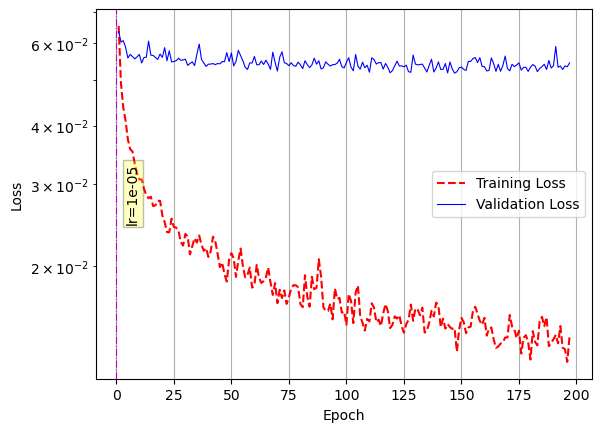

<Figure size 640x480 with 0 Axes>

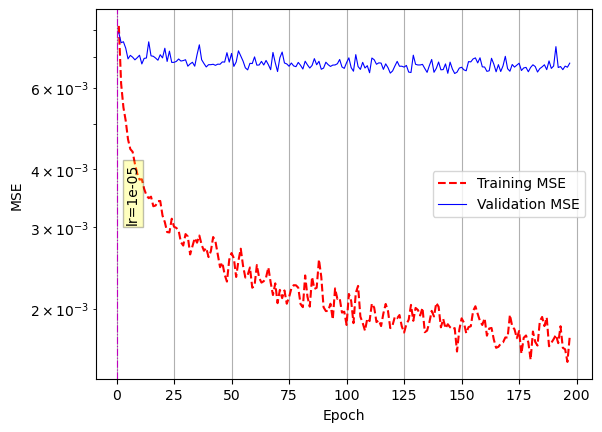

<Figure size 640x480 with 0 Axes>

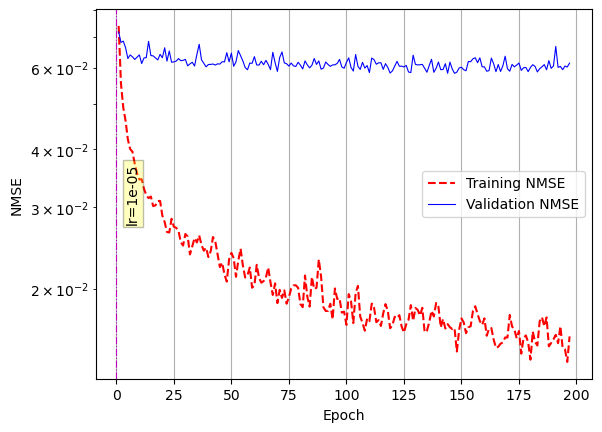

<Figure size 640x480 with 0 Axes>

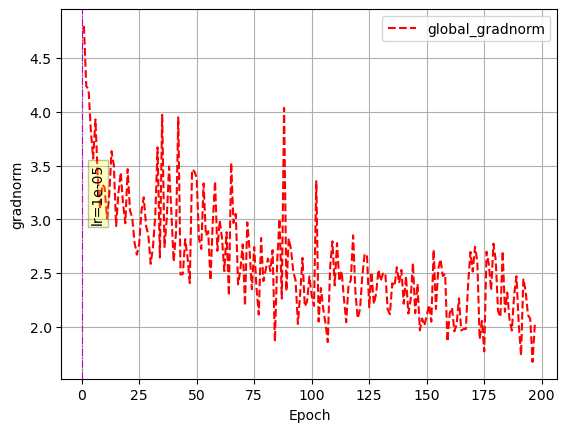

<Figure size 640x480 with 0 Axes>

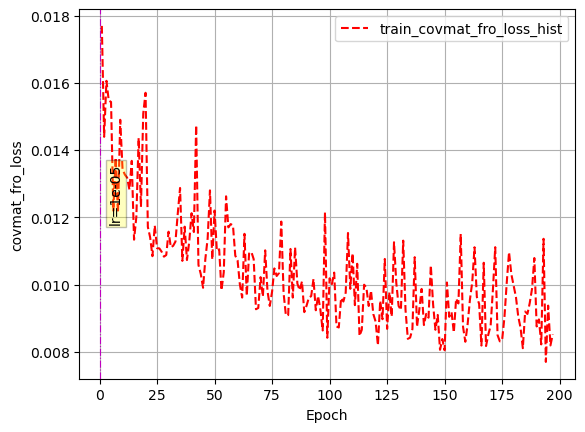



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 4.275
(362, 62, 5000) (362, 30, 5000)


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
18/18 [==============================] - ETA: 0s - loss: 0.1189 - mse: 0.0194 - NMSE: 0.1756 - covmat_fro_loss: 0.0187 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 1m 58.7s

Epoch 1: val_NMSE improved from inf to 0.20852, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-30_outsteps
 - saving l

18/18 [==============================] - ETA: 0s - loss: 0.0699 - mse: 0.0111 - NMSE: 0.1005 - covmat_fro_loss: 0.0158 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 4m 57.2s

Epoch 9: val_NMSE did not improve from 0.17776
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 20s 1s/step - loss: 0.0699 - mse: 0.0111 - NMSE: 0.1005 - covmat_fro_loss: 0.0159 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1231 - val_mse: 0.0199 - val_NMSE: 0.1799 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
18/18 [==============================] - ETA: 0s - loss: 0.0700 - mse: 0.0111 - NMSE: 0.1003 - covmat_fro_loss: 0.0160 - global_gradnorm: 4.2750 - rho_r

18/18 [==============================] - ETA: 0s - loss: 0.0582 - mse: 0.0092 - NMSE: 0.0829 - covmat_fro_loss: 0.0150 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 8m 15.8s

Epoch 18: val_NMSE did not improve from 0.16711
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 20s 1s/step - loss: 0.0582 - mse: 0.0092 - NMSE: 0.0829 - covmat_fro_loss: 0.0151 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1213 - val_mse: 0.0196 - val_NMSE: 0.1775 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 19/1000
18/18 [==============================] - ETA: 0s - loss: 0.0579 - mse: 0.0091 - NMSE: 0.0826 - covmat_fro_loss: 0.0150 - global_gradnorm: 4.2750 - rho_

Epoch 28/1000
18/18 [==============================] - ETA: 0s - loss: 0.0545 - mse: 0.0086 - NMSE: 0.0775 - covmat_fro_loss: 0.0147 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 11m 42.8s

Epoch 28: val_NMSE did not improve from 0.16288
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 21s 1s/step - loss: 0.0545 - mse: 0.0086 - NMSE: 0.0775 - covmat_fro_loss: 0.0147 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1184 - val_mse: 0.0191 - val_NMSE: 0.1729 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 29/1000
18/18 [==============================] - ETA: 0s - loss: 0.0523 - mse: 0.0082 - NMSE: 0.0743 - covmat_fro_loss: 0.0145 - global_gradnorm

Epoch 38/1000
18/18 [==============================] - ETA: 0s - loss: 0.0520 - mse: 0.0082 - NMSE: 0.0738 - covmat_fro_loss: 0.0145 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 15m 11.8s

Epoch 38: val_NMSE did not improve from 0.16244
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 21s 1s/step - loss: 0.0520 - mse: 0.0082 - NMSE: 0.0738 - covmat_fro_loss: 0.0145 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1159 - val_mse: 0.0187 - val_NMSE: 0.1691 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 39/1000
18/18 [==============================] - ETA: 0s - loss: 0.0505 - mse: 0.0079 - NMSE: 0.0715 - covmat_fro_loss: 0.0143 - global_gradnorm

Epoch 48/1000
18/18 [==============================] - ETA: 0s - loss: 0.0484 - mse: 0.0076 - NMSE: 0.0687 - covmat_fro_loss: 0.0141 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 18m 40.0s

Epoch 48: val_NMSE did not improve from 0.16244
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 21s 1s/step - loss: 0.0484 - mse: 0.0076 - NMSE: 0.0687 - covmat_fro_loss: 0.0140 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1162 - val_mse: 0.0187 - val_NMSE: 0.1697 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 49/1000
18/18 [==============================] - ETA: 0s - loss: 0.0508 - mse: 0.0080 - NMSE: 0.0721 - covmat_fro_loss: 0.0144 - global_gradnorm

Epoch 58/1000
18/18 [==============================] - ETA: 0s - loss: 0.0461 - mse: 0.0072 - NMSE: 0.0652 - covmat_fro_loss: 0.0138 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 22m 7.9s

Epoch 58: val_NMSE did not improve from 0.16049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 21s 1s/step - loss: 0.0461 - mse: 0.0072 - NMSE: 0.0652 - covmat_fro_loss: 0.0137 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1168 - val_mse: 0.0189 - val_NMSE: 0.1706 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 59/1000
18/18 [==============================] - ETA: 0s - loss: 0.0477 - mse: 0.0075 - NMSE: 0.0676 - covmat_fro_loss: 0.0141 - global_gradnorm:

Epoch 68/1000
18/18 [==============================] - ETA: 0s - loss: 0.0438 - mse: 0.0068 - NMSE: 0.0619 - covmat_fro_loss: 0.0136 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 25m 34.4s

Epoch 68: val_NMSE did not improve from 0.16049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 21s 1s/step - loss: 0.0438 - mse: 0.0068 - NMSE: 0.0619 - covmat_fro_loss: 0.0136 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1199 - val_mse: 0.0194 - val_NMSE: 0.1754 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 69/1000
18/18 [==============================] - ETA: 0s - loss: 0.0458 - mse: 0.0072 - NMSE: 0.0647 - covmat_fro_loss: 0.0139 - global_gradnorm

Epoch 78/1000
18/18 [==============================] - ETA: 0s - loss: 0.0429 - mse: 0.0067 - NMSE: 0.0605 - covmat_fro_loss: 0.0136 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 29m 2.5s

Epoch 78: val_NMSE did not improve from 0.16049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 21s 1s/step - loss: 0.0429 - mse: 0.0067 - NMSE: 0.0605 - covmat_fro_loss: 0.0138 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1155 - val_mse: 0.0186 - val_NMSE: 0.1686 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 79/1000
18/18 [==============================] - ETA: 0s - loss: 0.0421 - mse: 0.0066 - NMSE: 0.0593 - covmat_fro_loss: 0.0134 - global_gradnorm:

Epoch 88/1000
18/18 [==============================] - ETA: 0s - loss: 0.0399 - mse: 0.0062 - NMSE: 0.0564 - covmat_fro_loss: 0.0131 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 32m 31.5s

Epoch 88: val_NMSE did not improve from 0.15910
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 21s 1s/step - loss: 0.0399 - mse: 0.0062 - NMSE: 0.0564 - covmat_fro_loss: 0.0131 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1165 - val_mse: 0.0188 - val_NMSE: 0.1702 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 89/1000
18/18 [==============================] - ETA: 0s - loss: 0.0432 - mse: 0.0068 - NMSE: 0.0611 - covmat_fro_loss: 0.0136 - global_gradnorm

Epoch 98/1000
18/18 [==============================] - ETA: 0s - loss: 0.0382 - mse: 0.0059 - NMSE: 0.0538 - covmat_fro_loss: 0.0130 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 35m 59.1s

Epoch 98: val_NMSE did not improve from 0.15910
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 21s 1s/step - loss: 0.0382 - mse: 0.0059 - NMSE: 0.0538 - covmat_fro_loss: 0.0130 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1152 - val_mse: 0.0186 - val_NMSE: 0.1682 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 99/1000
18/18 [==============================] - ETA: 0s - loss: 0.0413 - mse: 0.0064 - NMSE: 0.0583 - covmat_fro_loss: 0.0134 - global_gradnorm

Epoch 108/1000
18/18 [==============================] - ETA: 0s - loss: 0.0402 - mse: 0.0063 - NMSE: 0.0569 - covmat_fro_loss: 0.0132 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 39m 21.7s

Epoch 108: val_NMSE did not improve from 0.15910
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 20s 1s/step - loss: 0.0402 - mse: 0.0063 - NMSE: 0.0569 - covmat_fro_loss: 0.0132 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1235 - val_mse: 0.0200 - val_NMSE: 0.1814 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 109/1000
18/18 [==============================] - ETA: 0s - loss: 0.0395 - mse: 0.0062 - NMSE: 0.0560 - covmat_fro_loss: 0.0130 - global_gradn

Epoch 118/1000
18/18 [==============================] - ETA: 0s - loss: 0.0393 - mse: 0.0061 - NMSE: 0.0555 - covmat_fro_loss: 0.0131 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 42m 45.0s

Epoch 118: val_NMSE did not improve from 0.15910
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 20s 1s/step - loss: 0.0393 - mse: 0.0061 - NMSE: 0.0555 - covmat_fro_loss: 0.0130 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1204 - val_mse: 0.0195 - val_NMSE: 0.1764 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 119/1000
18/18 [==============================] - ETA: 0s - loss: 0.0401 - mse: 0.0063 - NMSE: 0.0566 - covmat_fro_loss: 0.0132 - global_gradn

Epoch 128/1000
18/18 [==============================] - ETA: 0s - loss: 0.0389 - mse: 0.0061 - NMSE: 0.0548 - covmat_fro_loss: 0.0131 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 46m 9.0s

Epoch 128: val_NMSE did not improve from 0.15910
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 21s 1s/step - loss: 0.0389 - mse: 0.0061 - NMSE: 0.0548 - covmat_fro_loss: 0.0133 - global_gradnorm: 4.2750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1151 - val_mse: 0.0186 - val_NMSE: 0.1680 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 129/1000
18/18 [==============================] - ETA: 0s - loss: 0.0381 - mse: 0.0059 - NMSE: 0.0537 - covmat_fro_loss: 0.0129 - global_gradno

Epoch 137: early stopping


<Figure size 640x480 with 0 Axes>

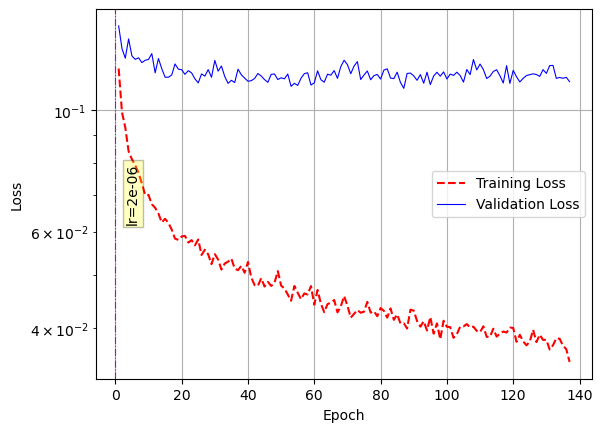

<Figure size 640x480 with 0 Axes>

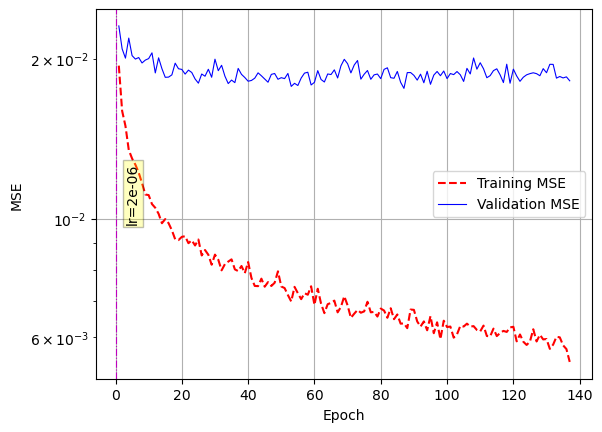

<Figure size 640x480 with 0 Axes>

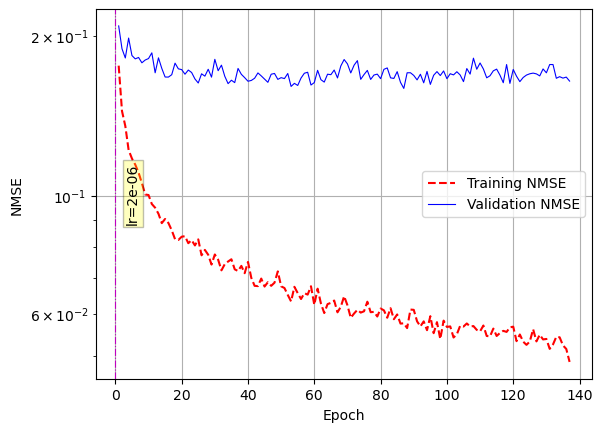

<Figure size 640x480 with 0 Axes>

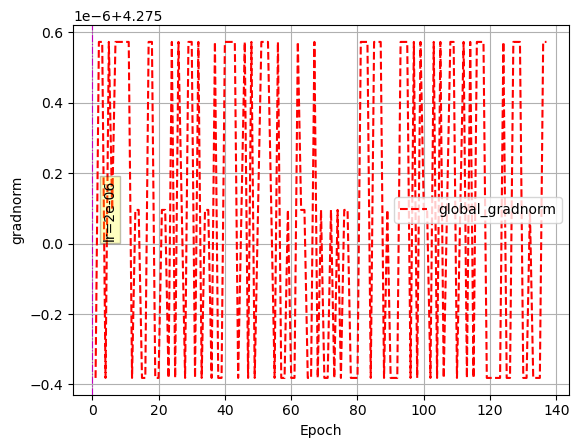

<Figure size 640x480 with 0 Axes>

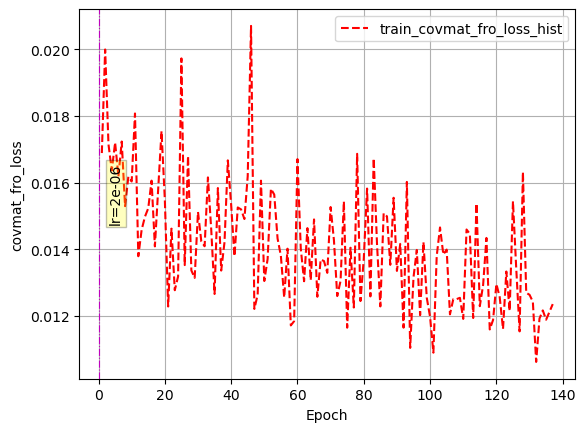



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 3.825
(297, 62, 5000) (297, 50, 5000)


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
14/14 [==============================] - ETA: 0s - loss: 0.1187 - mse: 0.0251 - NMSE: 0.2278 - covmat_fro_loss: 0.0164 - global_gradnorm: 3.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 2m 34.3s

Epoch 1: val_NMSE improved from inf to 0.29719, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-50_outsteps
 - saving l

14/14 [==============================] - ETA: 0s - loss: 0.0753 - mse: 0.0152 - NMSE: 0.1381 - covmat_fro_loss: 0.0146 - global_gradnorm: 3.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 5m 46.6s

Epoch 9: val_NMSE did not improve from 0.22141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 24s 2s/step - loss: 0.0753 - mse: 0.0152 - NMSE: 0.1381 - covmat_fro_loss: 0.0146 - global_gradnorm: 3.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1286 - val_mse: 0.0266 - val_NMSE: 0.2407 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
14/14 [==============================] - ETA: 0s - loss: 0.0743 - mse: 0.0151 - NMSE: 0.1365 - covmat_fro_loss: 0.0145 - global_gradnorm: 3.8250 - rho_r

Epoch 19/1000
14/14 [==============================] - ETA: 0s - loss: 0.0691 - mse: 0.0140 - NMSE: 0.1266 - covmat_fro_loss: 0.0142 - global_gradnorm: 3.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 9m 45.4s

Epoch 19: val_NMSE did not improve from 0.21350
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 24s 2s/step - loss: 0.0691 - mse: 0.0140 - NMSE: 0.1266 - covmat_fro_loss: 0.0142 - global_gradnorm: 3.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1282 - val_mse: 0.0266 - val_NMSE: 0.2407 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 20/1000
14/14 [==============================] - ETA: 0s - loss: 0.0651 - mse: 0.0130 - NMSE: 0.1180 - covmat_fro_loss: 0.0140 - global_gradnorm:

Epoch 29/1000
14/14 [==============================] - ETA: 0s - loss: 0.0617 - mse: 0.0123 - NMSE: 0.1113 - covmat_fro_loss: 0.0137 - global_gradnorm: 3.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 13m 41.6s

Epoch 29: val_NMSE did not improve from 0.21350
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 24s 2s/step - loss: 0.0617 - mse: 0.0123 - NMSE: 0.1113 - covmat_fro_loss: 0.0137 - global_gradnorm: 3.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1188 - val_mse: 0.0246 - val_NMSE: 0.2219 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 30/1000
14/14 [==============================] - ETA: 0s - loss: 0.0611 - mse: 0.0122 - NMSE: 0.1107 - covmat_fro_loss: 0.0137 - global_gradnorm

Epoch 39/1000
14/14 [==============================] - ETA: 0s - loss: 0.0579 - mse: 0.0115 - NMSE: 0.1041 - covmat_fro_loss: 0.0134 - global_gradnorm: 3.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 18m 28.3s

Epoch 39: val_NMSE did not improve from 0.21350
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 24s 2s/step - loss: 0.0579 - mse: 0.0115 - NMSE: 0.1041 - covmat_fro_loss: 0.0134 - global_gradnorm: 3.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1241 - val_mse: 0.0257 - val_NMSE: 0.2327 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 40/1000
14/14 [==============================] - ETA: 0s - loss: 0.0566 - mse: 0.0112 - NMSE: 0.1019 - covmat_fro_loss: 0.0133 - global_gradnorm

Epoch 49/1000
14/14 [==============================] - ETA: 0s - loss: 0.0558 - mse: 0.0110 - NMSE: 0.0999 - covmat_fro_loss: 0.0133 - global_gradnorm: 3.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 22m 29.9s

Epoch 49: val_NMSE did not improve from 0.21350
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 24s 2s/step - loss: 0.0558 - mse: 0.0110 - NMSE: 0.0999 - covmat_fro_loss: 0.0132 - global_gradnorm: 3.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1206 - val_mse: 0.0249 - val_NMSE: 0.2254 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 50/1000
14/14 [==============================] - ETA: 0s - loss: 0.0563 - mse: 0.0112 - NMSE: 0.1010 - covmat_fro_loss: 0.0133 - global_gradnorm

Epoch 59/1000
14/14 [==============================] - ETA: 0s - loss: 0.0542 - mse: 0.0107 - NMSE: 0.0967 - covmat_fro_loss: 0.0131 - global_gradnorm: 3.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 26m 31.2s

Epoch 59: val_NMSE did not improve from 0.21350
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 24s 2s/step - loss: 0.0542 - mse: 0.0107 - NMSE: 0.0967 - covmat_fro_loss: 0.0131 - global_gradnorm: 3.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1290 - val_mse: 0.0269 - val_NMSE: 0.2433 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 60/1000
14/14 [==============================] - ETA: 0s - loss: 0.0568 - mse: 0.0113 - NMSE: 0.1023 - covmat_fro_loss: 0.0133 - global_gradnorm

<Figure size 640x480 with 0 Axes>

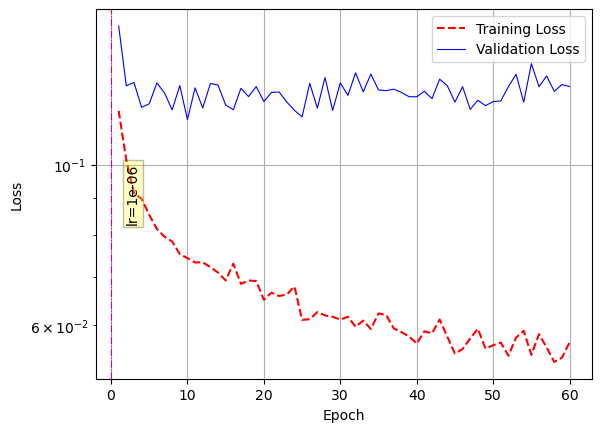

<Figure size 640x480 with 0 Axes>

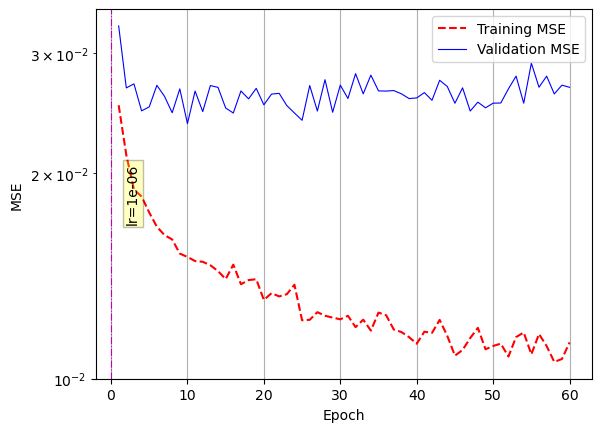

<Figure size 640x480 with 0 Axes>

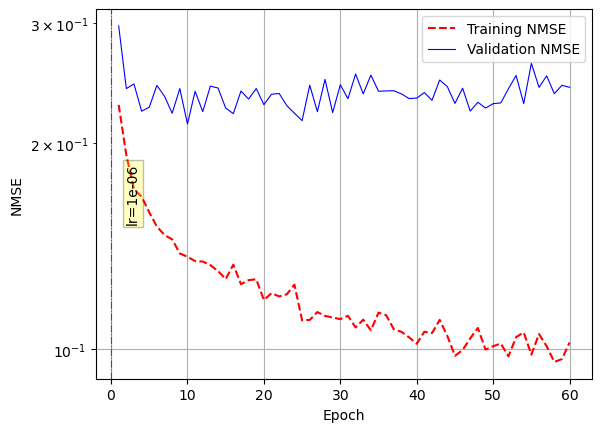

<Figure size 640x480 with 0 Axes>

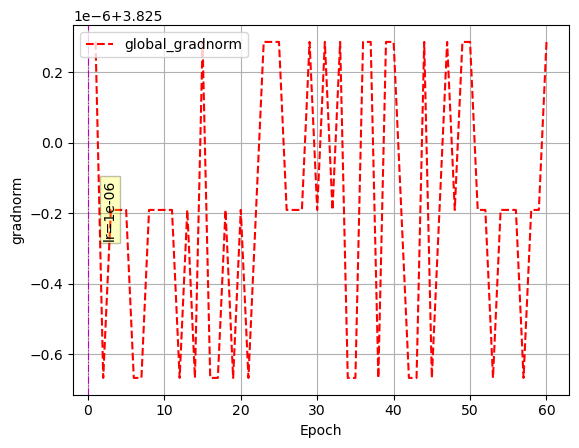

<Figure size 640x480 with 0 Axes>

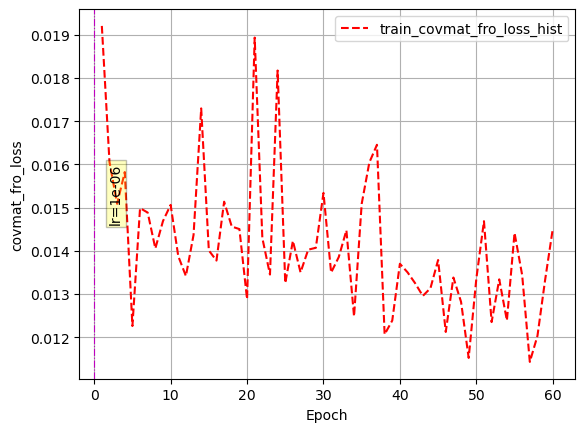

<Figure size 640x480 with 0 Axes>

In [23]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    if behaviour == 'loadCheckpointAndContinueTraining':
        if kk < len(T_sample_output) - 1:
            temp = int((T_sample_output[kk+1] + 0.5*dt_rnn)//dt_rnn)
        else:
            temp = num_outsteps
        checkfile1 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(temp)
        checkfile2 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(temp)
        check1 = os.path.exists(checkfile1)
        check2 = os.path.exists(checkfile2)
        if check1 and check2:
            # move on to checking the next time-step
            continue
        else:
            pass
    
    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_ESN,
        all_data,
        AR_AERNN_ESN,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=[all_data.shape[0]],# boundary_idx_arr,
        delta_t=dt_rnn,#delta_t,
        # params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        ESN_flag=True,
        rnn_kwargs=rnn_kwargs,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.9 * 0.25 * np.round(4*global_clipnorm)

In [24]:
batch_size*np.round(int(all_data.shape[0]*0.8)/batch_size)

26672.0

In [25]:
### Training the combined AE-RNN
# %pdb

In [26]:
normalization_constant_arr_aedata.shape

(2, 2, 50, 50)

# 